In [3]:
import torch
from typing import Any
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from Traj2Dataset import TrajDataset, DatasetTransform
from torch.utils.data import DataLoader, SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import seed_everything

In [4]:
class Net(nn.Module):
    def __init__(self, in_dims, out_dims):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dims, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, out_dims)
        )

    def forward(self, x):
        return self.layers(x)

In [5]:
class LitMLP(pl.LightningModule):
    def __init__(
        self,
        in_dims: int,
        out_dims: int,
        lr: float = 1e-3,
        *args: Any,
        **kwargs: Any
    ) -> None:
        super().__init__(*args, **kwargs)

        self.model = Net(in_dims, out_dims)
        self.lr = lr

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)


### HYPERPARAMETERS

In [6]:
root_dir = 'dataset'
system = 'great-wine-beetle'
validation_split = 0.2
learning_rate = 1e-3
batch_size = 32
max_epochs = 100
shuffle = True
SEED = 42
logdir = './logs/'
num_workers = 4

seed_everything(SEED)

Global seed set to 42


42

### TRAINING AND VALIDATION DATASET PREPARATION

In [7]:
train_dataset = TrajDataset(system, root_dir)

state_dim = len(train_dataset.states)
action_dim = len(train_dataset.actions)

mean = [x['mean'] for x in train_dataset.states]  # mean
std = [x['std'] for x in train_dataset.states]   # std_dev
transform = DatasetTransform(mean, std)

target_mean = [x['mean'] for x in train_dataset.actions]  # mean
target_std = [x['std'] for x in train_dataset.actions]   # std_dev
target_transform = DatasetTransform(target_mean, target_std)

train_dataset.tranform = transform
train_dataset.target_transform = target_transform

test_dataset = TrajDataset(system, root_dir, train=False,
                           transform=transform,
                           target_transform=target_transform)
indices = np.arange(len(train_dataset))

if shuffle is True:
    np.random.shuffle(indices)

split = int(validation_split * len(train_dataset))
train_indices = indices[split:]
valid_indices = indices[:split]

# may use wandb later
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)


In [8]:
callbacks = []

tb_logger = loggers.TensorBoardLogger(logdir)

train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size, num_workers=num_workers,
                              sampler=train_sampler)
valid_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size, num_workers=num_workers,
                              sampler=valid_sampler)
model = LitMLP(state_dim, action_dim, learning_rate)
trainer = pl.Trainer(
    gpus=1, logger=tb_logger,
    callbacks=callbacks,
    progress_bar_refresh_rate=60,
    max_epochs=max_epochs,)

trainer.fit(model, train_dataloader, valid_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 788   
-------------------------------
788       Trainable params
0         Non-trainable params
788       Total params
0.003     Total estimated model params size (MB)


Global seed set to 42


Epoch 99: 100%|██████████| 119/119 [00:01<00:00, 115.71it/s, loss=0.332, v_num=6]


In [ ]:
# logs = trainer.test(model,test_dataloader,verbose=False)
# print(logs)
def upscale(x):
    return x * torch.Tensor(target_std) + torch.Tensor(target_mean)


test_dataloader = DataLoader(test_dataset,
                             batch_size=1, shuffle=False,
                             num_workers=0)

for i, (x, y) in enumerate(test_dataloader):
    print(f'Time-step: {i}')
    print(f'Target: {upscale(y)}')
    print(f'Prediction: {upscale(model(x))}')


['X', 'Y', 'X1', 'Y1', 'dX', 'dY', 'dX1', 'dY1', 'Xt', 'Yt']


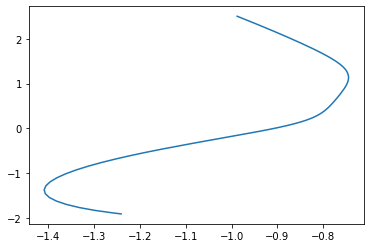

In [10]:
from matplotlib import pyplot as plt

targets = []
test_dataset = TrajDataset(system,root_dir,train = False)
print(test_dataset.states)

# first two states are X,Y for end-effectors
for i,(x,_) in enumerate(test_dataset):
    targets.append(x[0:2])
targets = np.array(targets)
plt.plot(targets[:,0],targets[:,1])

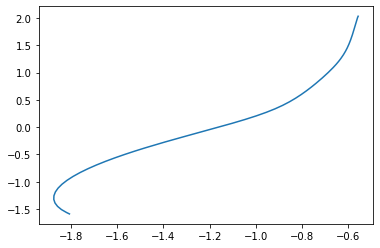

In [15]:
targets = []
train_dataset = TrajDataset(system, root_dir, train=True)

# first two states are X,Y for end-effectors
traj_ID = 3
for i, (x, _) in enumerate(train_dataset):
    # each trajectory is a slice of 200 points in dataset
    if i in range(200*traj_ID, 200*(traj_ID+1)):
        targets.append(x[:2])
targets = np.array(targets)
plt.plot(targets[:, 0], targets[:, 1])
